In [16]:
!pip install tensorflow-gpu
!pip install -U -q PyDrive

In [17]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
#from tensorflow.python.keras import backend as K
import glob
import math
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, BatchNormalization, Dropout, Reshape, LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [19]:
all_files = glob.glob("/gdrive/My Drive/Colab Notebooks/data/autopilot_*.csv")
#all_files = glob.glob("data/autopilot_2019_03_18__13_20_22.csv")

li = []
iFile = 0
for filename in all_files:
    iFile = iFile+1
    print(iFile * '=' + (len(all_files) - iFile) * '.', "Loading", filename, end='\r')
    df = pd.read_csv(filename, header=None)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df.sample(frac=1))

print("Concat all")
dataset = pd.concat(li, axis=0).sample(frac=1)
#dataset = dataset.iloc[:int(dataset.shape[0] * .2),:]
#DEV TO REDUCE DATASET
#dataset = dataset.iloc[:1000,:]

print("Done")


Concat all
Done


In [20]:
#DEBUG REDUC DATASET
Y_data = dataset.iloc[:,-2:]
X_data = dataset.iloc[:,:-2]


split_offset = int(X_data.shape[0] * .05)
Y_test  = Y_data.iloc[:split_offset,:]
Y_train = Y_data.iloc[split_offset:,:]
X_test  = X_data.iloc[:split_offset,:]
X_train = X_data.iloc[split_offset:,:]
assert X_train.shape[1] == X_test.shape[1]
assert Y_train.shape[1] == Y_test.shape[1]
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(X_train.shape[1], "feature values")
print(Y_train.shape[1], "output values")
print(X_train.shape[0], "training lines")
print(Y_test.shape[0], "testing lines")

#dataset.describe()

2271 feature values
2 output values
89756 training lines
4723 testing lines


In [35]:
first_selfcar_inputs = 3
features_by_car = 6
cells_by_row = round(math.sqrt((X_train.shape[1] - 3) / (features_by_car + 1)))
car_features = cells_by_row * cells_by_row * features_by_car
blocks_offset = first_selfcar_inputs + car_features

raw_input = Input(shape=(X_train.shape[1],), name='raw_input')

selfcar = Lambda(
    lambda x: K.slice(x, [0,0], [-1,first_selfcar_inputs]),
    output_shape=(first_selfcar_inputs,),
    name='selfcar_input'
)(raw_input)

blocks = Lambda(
    lambda x: K.slice(x, [0,blocks_offset], [-1,-1]),
    output_shape=(cells_by_row * cells_by_row,),
    name='blocks_input_slice'
)(raw_input)

blocks = Reshape(
    (cells_by_row, cells_by_row, 1,),
    input_shape=(cells_by_row, cells_by_row, 1,),
    name='blocks_input_reshape'
)(blocks)

cars = Lambda(
    lambda x: K.slice(x, [0,first_selfcar_inputs], [-1,car_features]),
    output_shape=(car_features,),
    name='cars_input_slice'
)(raw_input)

cars = Reshape(
    (cells_by_row, cells_by_row, features_by_car,),
    input_shape=(cells_by_row * cells_by_row * features_by_car,),
    name='cars_input_reshape'
)(cars)

reluActivation = LeakyReLU(name='leaky_relu')

selfcar = BatchNormalization()(selfcar)
selfcar = Dense(4, activation=reluActivation, name='dense_selfcar_1')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation=reluActivation, name='dense_selfcar_2')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation=reluActivation, name='dense_selfcar_3')(selfcar)
selfcar = Dropout(.2)(selfcar)

blocks = Conv2D(8, (4, 4), padding='same', name='conv_blocks_0')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Conv2D(16, (2, 2), name='conv_blocks_1')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_1')(blocks)
blocks = Conv2D(32, (2, 2), name='conv_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_2')(blocks)
blocks = Conv2D(64, (1, 1), name='conv_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_3')(blocks)
blocks = Conv2D(128, (1, 1), name='conv_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Flatten(name='flatten_blocks')(blocks)
blocks = Dropout(.2)(blocks)
blocks = Dense(32, activation=reluActivation, name='dense_blocks_1')(Concatenate()([blocks, selfcar]))
blocks = BatchNormalization()(blocks)
blocks = Dense(16, activation=reluActivation, name='dense_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(8, activation=reluActivation, name='dense_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(4, activation=reluActivation, name='dense_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(2, activation=reluActivation, name='dense_blocks_5')(blocks)

cars = Conv2D(8, (2, 2), padding='same', name='conv_cars_0')(cars)
cars = BatchNormalization()(cars)
cars = Conv2D(16, (1, 1), name='conv_cars_1')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_1')(cars)
cars = Conv2D(32, (1, 1), name='conv_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_2')(cars)
cars = Conv2D(64, (1, 1), name='conv_cars_3')(cars)
cars = BatchNormalization()(cars)
cars = Dropout(.2)(cars)
cars = MaxPooling2D((2, 2), name='max_cars_3')(cars)
cars = Flatten(name='flatten_cars')(cars)
cars = Dense(8, activation=reluActivation, name='dense_cars_1')(Concatenate()([cars, selfcar]))
cars = BatchNormalization()(cars)
cars = Dense(4, activation=reluActivation, name='dense_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = Dense(2, activation=reluActivation, name='dense_cars_3')(cars)

all_features = Concatenate(name='all_features')([blocks, cars, selfcar])
all_features = BatchNormalization()(all_features)
all_features = Dropout(.1)(all_features)
all_features = Dense(8, activation=reluActivation)(all_features)
all_features = BatchNormalization()(all_features)
all_features = Dense(4, activation=reluActivation)(all_features)
all_features = BatchNormalization()(all_features)
driving = Dense(2, activation='tanh')(all_features)


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
def acceptation(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true) < .2, axis=-1)

def create_model():
  model = Model(inputs=raw_input, outputs=driving)
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[acceptation])
  return model

def model_evaluated(X_train, Y_train, X_test, Y_test, params):
  print(params)
  model = create_model()
  lrate = LearningRateScheduler(lambda epoch: params['initial_lrate'] * math.pow(params['drop'], math.floor((1+epoch)/params['epochs_drop'])), verbose=1)
  history = model.fit(X_train, Y_train, epochs=params['epochs'], batch_size=512, callbacks=[lrate], validation_data=(X_test, Y_test))

  return history, model


In [37]:
create_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_input (InputLayer)          (None, 2271)         0                                            
__________________________________________________________________________________________________
blocks_input_slice (Lambda)     (None, 324)          0           raw_input[0][0]                  
__________________________________________________________________________________________________
blocks_input_reshape (Reshape)  (None, 18, 18, 1)    0           blocks_input_slice[0][0]         
__________________________________________________________________________________________________
conv_blocks_0 (Conv2D)          (None, 18, 18, 8)    136         blocks_input_reshape[0][0]       
__________________________________________________________________________________________________
batch_norm

In [0]:
histories = {}

In [40]:
p = {
    'epochs': 50,
    'try' : 2, 
    'initial_lrate' : 0.1,
    'drop' : 0.8,
    'epochs_drop' : 3,
    'add_dropout' : 1
}
history, model = model_evaluated(X_train, Y_train, X_test, Y_test, p)
histories[str(p)] = history

{'epochs': 50, 'try': 2, 'initial_lrate': 0.1, 'drop': 0.8, 'epochs_drop': 3, 'add_dropout': 1}
Train on 89756 samples, validate on 4723 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
89756/89756 [==============================] - 34s 380us/step - loss: 0.1007 - acceptation: 0.5875 - val_loss: 0.2312 - val_acceptation: 0.3900
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
89756/89756 [==============================] - 22s 243us/step - loss: 0.0989 - acceptation: 0.5899 - val_loss: 0.1373 - val_acceptation: 0.4861
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.08000000000000002.
89756/89756 [==============================] - 22s 246us/step - loss: 0.0963 - acceptation: 0.5946 - val_loss: 0.1656 - val_acceptation: 0.4456
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.08000000000000002.
89756/89756 [==============================] - 22s 242us/step - loss: 0.0958 - acce

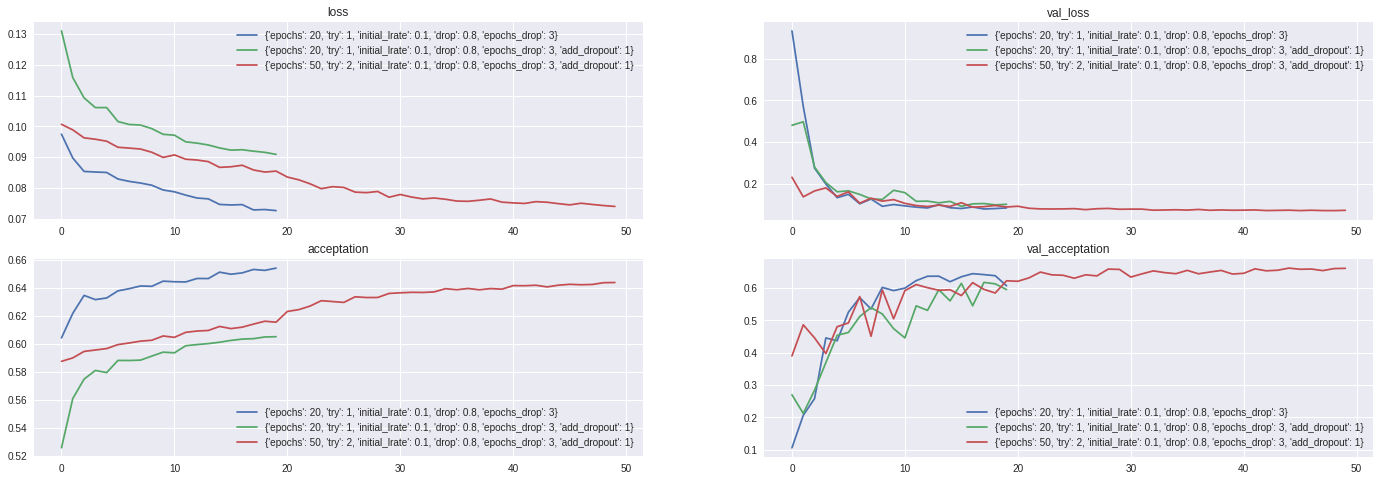

In [41]:
pyplot.figure(figsize=(24,8))

for i, f in enumerate(['loss', 'val_loss', 'acceptation', 'val_acceptation']):
  pyplot.subplot(2, 2, i+1)
  pyplot.title(f)
  for lr, h in histories.items():
    pyplot.plot(h.history[f], label=lr)
  pyplot.legend()
pyplot.show()

In [48]:
sess = K.get_session()
i_validation = 130
for index in range(i_validation, i_validation + 10):
  truth = Y_test.values[index]
  prediction = model.predict(X_test.values[index:index+1,:])[0]
  print(truth)
  print(prediction, sess.run(acceptation(truth, prediction)))
  print("---------")

[0.24202643 0.99162349]
[0.06191066 0.977002  ] 1.0
---------
[0.2974578  0.79239492]
[-0.00546743  0.864147  ] 0.5
---------
[-0.85000266  0.99587137]
[-0.6310874   0.96839017] 0.5
---------
[0.09699288 0.23403711]
[0.08844049 0.11138664] 1.0
---------
[-0.72985107  0.9773502 ]
[0.11626479 0.98815674] 0.5
---------
[-0.49486521 -0.13762052]
[-0.5192665  0.3249769] 0.5
---------
[-0.21999981  0.98914646]
[-0.09188946  0.99505335] 1.0
---------
[-0.03366016 -0.76120657]
[ 0.0606497  -0.20980076] 0.5
---------
[-0.29316255  0.33281488]
[-0.21960625  0.199995  ] 1.0
---------
[ 0.09484759 -0.23569635]
[ 0.18161108 -0.11434536] 1.0
---------


In [45]:
import os, time
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    {"raw": model.input},
    {"drive": model.output}
)
export_path = os.path.join(
    tf.compat.as_bytes('models/export/{}'.format(model.name)),
    tf.compat.as_bytes('9')
)
builder = saved_model_builder.SavedModelBuilder(export_path)
sess = K.get_session()
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'raw': prediction_signature}
)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/model_9/9/saved_model.pb


b'models/export/model_9/9/saved_model.pb'

In [46]:
!tar czfv model9.tar.gz models/export/model_9/

models/export/model_9/
models/export/model_9/9/
models/export/model_9/9/variables/
models/export/model_9/9/variables/variables.index
models/export/model_9/9/variables/variables.data-00000-of-00001
models/export/model_9/9/saved_model.pb
